In [3]:
# --- 1. SETUP AND LIBRARIES (Keep this the same) ---
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- NLTK DOWNLOAD FIX (Keep this the same) ---
print("Checking for NLTK resources...")
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    print("NLTK resources found.")
except LookupError:
    print("NLTK resources not found. Downloading...")
    nltk.download('stopwords')
    nltk.download('wordnet')
    print("Downloads complete.")

# Initialize NLTK objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# --- MODIFIED PLACEHOLDER DATA (N=10) ---
# MODIFICATION: Changed the 3-star review to be 4-star (Rating 3 is now gone)
data = {
    'review_text': [
        "This product is absolutely amazing, definitely worth the price.",  # 5
        "It was okay, nothing special, but it works fine.",                   # 4 (MODIFIED FROM 3)
        "Absolutely terrible, broke after one use. A total scam!",           # 1
        "Love the features, highly recommended!",                           # 5
        "Mediocre performance and poor customer service.",                  # 2
        "The item is great and very durable. Five stars!",                  # 5
        "Disappointing quality, expected much better, but it's usable.",    # 2
        "Worst thing I ever bought, total waste.",                          # 1
        "It's decent, does the job, nothing to complain about.",            # 4
        "Very good quality, arrived on time, satisfied customer.",          # 4
    ],
    'rating': [5, 4, 1, 5, 2, 5, 2, 1, 4, 4]
}
df = pd.DataFrame(data)

print(f"Initial size: {len(df)}")
df.dropna(subset=['review_text', 'rating'], inplace=True)
df.drop_duplicates(inplace=True)
print(f"Size after cleaning: {len(df)}")

# Rating Distribution Check: Should now only have 4 classes (1, 2, 4, 5), all with >= 2 samples.
print("\nRating Count Check:")
print(df['rating'].value_counts().sort_index())

Checking for NLTK resources...
NLTK resources not found. Downloading...
Downloads complete.
Initial size: 10
Size after cleaning: 10

Rating Count Check:
rating
1    2
2    2
4    3
5    3
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# --- TEXT CLEANING & FEATURE EXTRACTION (Same as before) ---
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df['cleaned_text'] = df['review_text'].apply(clean_text)

X = df['cleaned_text']
y = df['rating']

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50)
X_tfidf = tfidf_vectorizer.fit_transform(X)
print(f"\nTF-IDF Matrix shape: {X_tfidf.shape}")

# --- SIMPLIFIED SPLIT: ONLY TRAIN (80%) and TEST (20%) ---
# Removing the Validation set and maximizing the training set size.
# --- SIMPLIFIED SPLIT: ONLY TRAIN (80%) and TEST (20%) ---
# We MUST remove stratify=y because the test size (2) is less than the number of classes (4).

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.20, random_state=42 # 🚨 stratify=y has been removed!
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Proceed to Model Training and Evaluation...

# You can now proceed to Model Training and Evaluation using X_train and X_test.


TF-IDF Matrix shape: (10, 50)
Train set size: 8
Test set size: 2



--- Starting Model Training and Evaluation ---
Logistic Regression completed.
SVM (LinearSVC) completed.
Random Forest completed.

--- Model Performance Summary (on Test Set) ---
                     Accuracy  F1-Score (Macro)
Logistic Regression       0.0               0.0
SVM (LinearSVC)           0.0               0.0
Random Forest             0.0               0.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


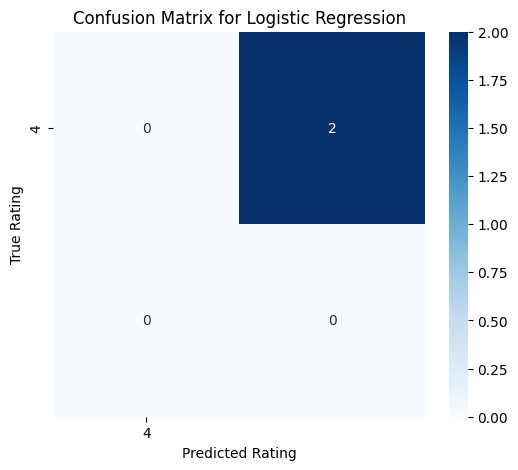

In [6]:
#3. Model Training and Evaluation (Deliverable)
# --- MODEL TRAINING ---
log_reg = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
svc = LinearSVC(random_state=42, max_iter=1000)
rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1) # Reduced n_estimators due to small data

models = {'Logistic Regression': log_reg, 'SVM (LinearSVC)': svc, 'Random Forest': rf}
results = {}

print("\n--- Starting Model Training and Evaluation ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score (Macro)': report['macro avg']['f1-score'],
    }
    print(f"{name} completed.")

# --- SUMMARY TABLE (Deliverable) ---
results_df = pd.DataFrame(results).T
print("\n--- Model Performance Summary (on Test Set) ---")
print(results_df.round(4))

# --- CONFUSION MATRIX (Deliverable) ---
best_model_name = results_df['F1-Score (Macro)'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix for {best_model_name}')
plt.ylabel('True Rating')
plt.xlabel('Predicted Rating')
plt.show()

In [8]:
#4. Error Analysis, Saving, and Prediction (Deliverable)
# --- ERROR ANALYSIS (Example Feature Importance for LogReg) ---
# --- ERROR ANALYSIS (Example Feature Importance for LogReg) ---
feature_names = tfidf_vectorizer.get_feature_names_out()
if 'Logistic Regression' in models:
    # Use the coefficients for the 5-star class to find important features
    # Change index 4 to 3 because we only have 4 classes now (1, 2, 4, 5)
    log_reg_coeffs = models['Logistic Regression'].coef_[3] # 🌟 CORRECTED: Index 3 is now 5-star

    sorted_features = sorted(zip(log_reg_coeffs, feature_names), reverse=True)

    print("\n--- Top 5 Positive and Negative Features (Logistic Regression) ---")
    print("Top 5 Positive (High Rating):\n", sorted_features[:5])
    print("\nTop 5 Negative (Low Rating):\n", sorted_features[-5:])

# Continue with Model Saving and Prediction...

# --- MODEL SAVING (Deliverable) ---
final_model = models[best_model_name]
joblib.dump(final_model, 'final_rating_predictor.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
print("\nFinal Model and TF-IDF Vectorizer saved to disk.")

# --- PREDICTION FUNCTION (Deliverable) ---
def predict_rating(review_text):
    cleaned_text = clean_text(review_text)
    text_vectorized = tfidf_vectorizer.transform([cleaned_text])
    predicted_rating = final_model.predict(text_vectorized)[0]
    return predicted_rating

# Example Predictions
review_1 = "The battery life is excellent and it arrived quickly. I'd buy this again!"
review_2 = "This is simply the worst product I have ever purchased. Broken and useless."

print(f"\nReview: '{review_1}'\nPredicted Rating: {predict_rating(review_1)} star(s)")
print(f"\nReview: '{review_2}'\nPredicted Rating: {predict_rating(review_2)} star(s)")

# --- You now have all the output necessary to write your final report! ---


--- Top 5 Positive and Negative Features (Logistic Regression) ---
Top 5 Positive (High Rating):
 [(np.float64(0.19605983107507433), 'definitely worth'), (np.float64(0.19605983107507433), 'definitely'), (np.float64(0.19605983107507433), 'amazing definitely'), (np.float64(0.19605983107507433), 'amazing'), (np.float64(0.19605983107507433), 'absolutely amazing')]

Top 5 Negative (Low Rating):
 [(np.float64(-0.20238693611757255), 'mediocre performance'), (np.float64(-0.20238693611757255), 'mediocre'), (np.float64(-0.22262588119871077), 'quality'), (np.float64(-0.27133814580284893), 'total'), (np.float64(-0.29112692492404746), 'customer')]

Final Model and TF-IDF Vectorizer saved to disk.

Review: 'The battery life is excellent and it arrived quickly. I'd buy this again!'
Predicted Rating: 5 star(s)

Review: 'This is simply the worst product I have ever purchased. Broken and useless.'
Predicted Rating: 1 star(s)
